In [8]:
import pandas as pd
import ast

# Load and prepare data
df = pd.read_csv("Dataset/reviews_with_themes.csv")
original_df = pd.read_csv("Dataset/reviews_with_sentiment.csv")
df = df.merge(original_df[['review', 'bank']], on='review', how='left')

# Convert stringified lists to actual lists
df['themes'] = df['themes'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

def get_top_items(df, sentiment, n=3):
    return (df[df['sentiment_label'] == sentiment]
            .explode('themes')
            [lambda x: x['themes'] != 'Other']
            .groupby(['bank', 'themes'])
            .size()
            .reset_index(name='count'))

# Get top drivers and pain points
top_drivers = get_top_items(df, 'positive')
top_pain_points = get_top_items(df, 'negative')

# Print formatted results
def print_insights(title, data):
    print(f"\n=== {title} ===")
    for bank in df['bank'].unique():  # <-- referencing global df?
        bank_data = data[data['bank'] == bank].nlargest(3, 'count')
        if not bank_data.empty:
            print(f"\n{bank}:")
            print(bank_data[['themes', 'count']].to_string(index=False))

In [10]:
# Print  insights
print_insights("Top Drivers", top_drivers)


=== Top Drivers ===

Commercial Bank of Ethiopia:
          themes  count
    Transactions    375
Feature Requests    342
 App Performance    132

Dashen Bank:
          themes  count
Feature Requests     40
    Transactions     37
Interface Issues     21

Bank of Abyssinia:
          themes  count
Feature Requests     40
    Transactions     39
 App Performance     20


In [12]:
print_insights("Top Pain Points", top_pain_points)


=== Top Pain Points ===

Commercial Bank of Ethiopia:
          themes  count
    Transactions    187
 App Performance    165
Feature Requests    104

Dashen Bank:
         themes  count
App Performance      9
   Transactions      6
 Account Access      2

Bank of Abyssinia:
          themes  count
 App Performance     65
    Transactions     36
Feature Requests     29


In [13]:
# Enhanced bank comparison
bank_stats = (df.groupby(['bank', 'sentiment_label'])
               .size()
               .unstack(fill_value=0)
               .assign(net_sentiment=lambda x: x.get('positive', 0) - x.get('negative', 0),
                     positive_pct=lambda x: x['positive'] / (x['positive'] + x['negative'])))

print("\n=== Bank Comparison ===")
print(bank_stats[['positive', 'negative', 'net_sentiment', 'positive_pct']]
      .sort_values('net_sentiment', ascending=False))


=== Bank Comparison ===
sentiment_label              positive  negative  net_sentiment  positive_pct
bank                                                                        
Commercial Bank of Ethiopia      3338       736           2602      0.819342
Dashen Bank                       364        34            330      0.914573
Bank of Abyssinia                 459       268            191      0.631362


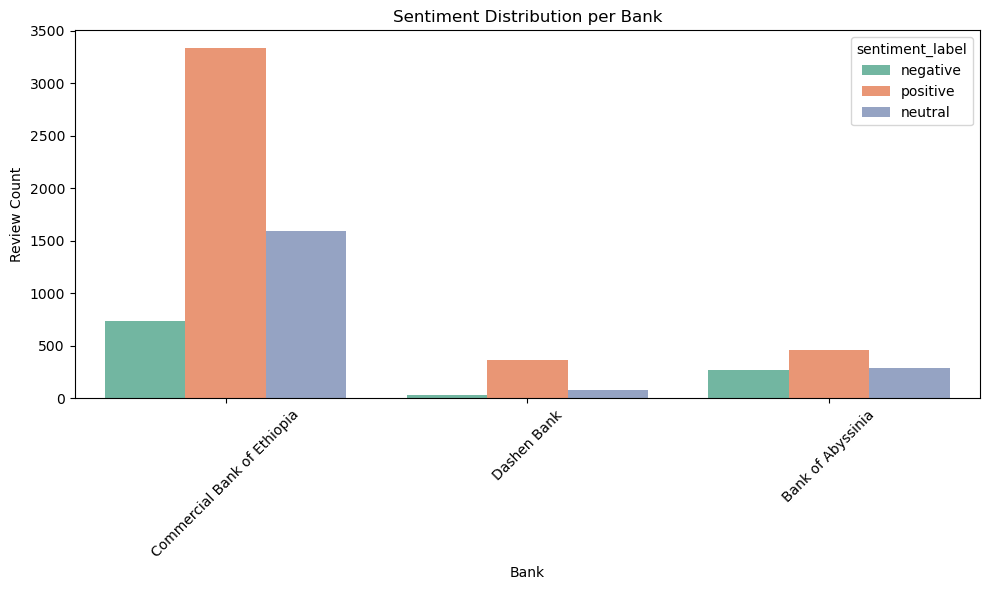

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='bank', hue='sentiment_label', palette='Set2')
plt.title('Sentiment Distribution per Bank')
plt.xlabel('Bank')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("images/sentiment_distribution_per_bank.png")
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_15968\3301785265.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_themes.values, y=top_themes.index, palette="viridis")


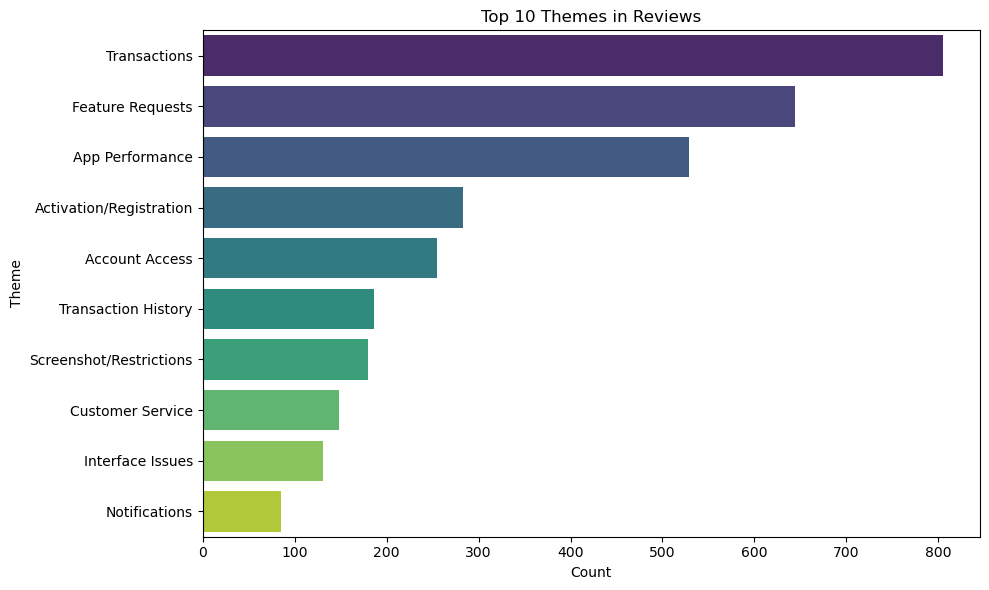

In [17]:
# Combine themes and sentiment
theme_sentiment = df.explode('themes')
theme_sentiment = theme_sentiment[theme_sentiment['themes'] != 'Other']

# Top 10 overall themes
top_themes = theme_sentiment['themes'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_themes.values, y=top_themes.index, palette="viridis")
plt.title("Top 10 Themes in Reviews")
plt.xlabel("Count")
plt.ylabel("Theme")
plt.tight_layout()
plt.savefig("images/top_10_themes.png")
plt.show()


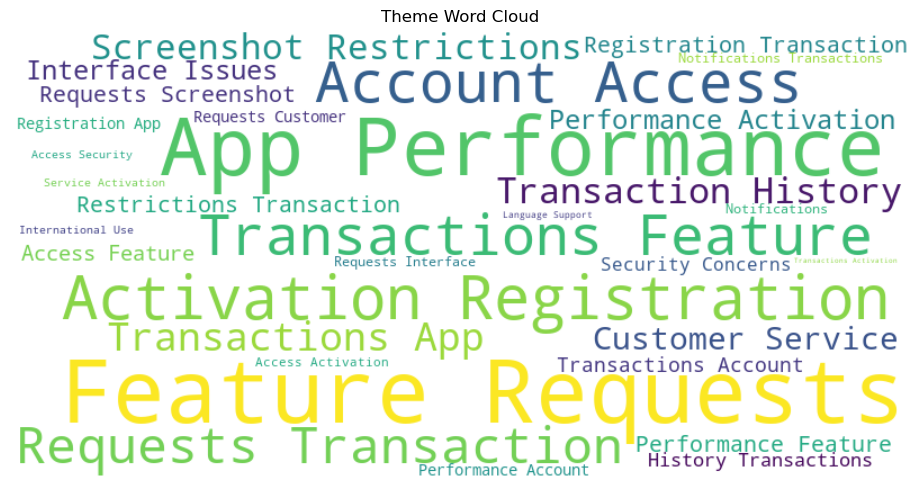

In [20]:
from wordcloud import WordCloud

# Flatten theme list
all_themes = theme_sentiment['themes'].dropna()
text = ' '.join(all_themes.astype(str).tolist())

# Generate WordCloud
wc = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title("Theme Word Cloud")
plt.tight_layout()
plt.savefig("images/theme_wordcloud.png")
plt.show()


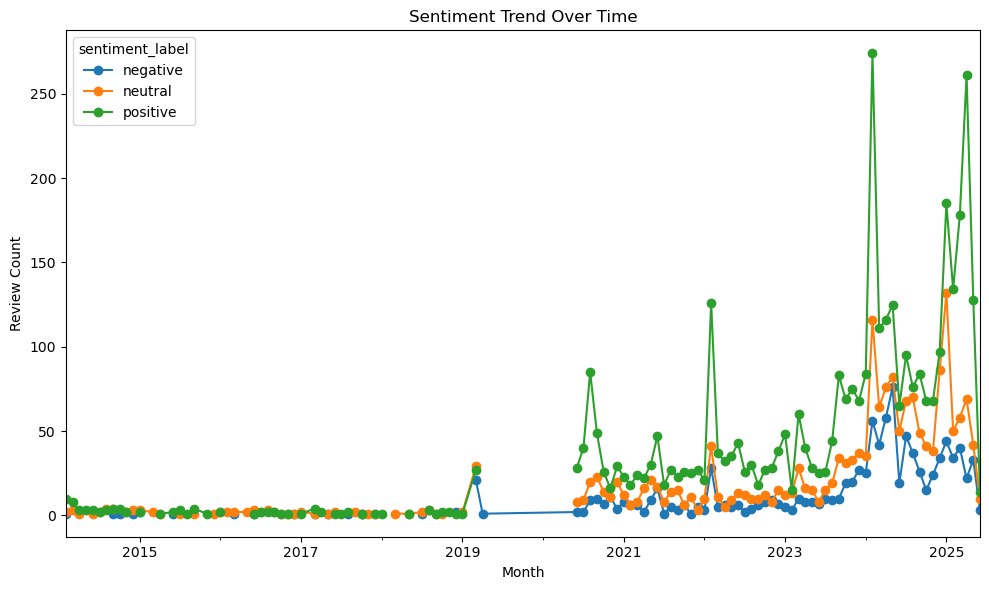

In [27]:
original_df['date'] = pd.to_datetime(original_df['date'])  # adjust if needed
sentiment_trend = original_df.groupby([original_df['date'].dt.to_period('M'), 'sentiment_label']).size().unstack()

sentiment_trend.plot(kind='line', figsize=(10, 6), marker='o')
plt.title("Sentiment Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Review Count")
plt.tight_layout()
plt.savefig("images/sentiment_trend_over_time.png")
plt.show()
